# Temporal Dynamics of Crop Correlations
## Time-Varying Correlations

This notebook tests if crop yield correlations change over time (a potential climate change signal).

**Key Questions:**
- Are crop yields becoming more correlated due to climate change?
- Are diversification benefits weakening over time?

In [10]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.analysis import CropDiversificationAnalysis

## 1. Load and Prepare Data

In [11]:
analysis = CropDiversificationAnalysis(
    rice_path="../data/rice",
    maize_path="../data/maize",
    wheat_path="../data/wheat",
    soybean_path="../data/soybean"
)

# Build standardized dataframe
df = analysis.build_dataframe()
print("Data shape:", df.shape)
print("Years covered:", int(df.index.min()), "-", int(df.index.max()))
df.head()

Data shape: (36, 4)
Years covered: 1981 - 2016


,rice,maize,wheat,soybean
year,,,,
1981,-2.356569,-1.678105,-4.088085,-2.101428
1982,-1.371636,-1.139752,-1.007664,-1.732231
1983,-1.415915,-1.501934,-0.608490,-1.683463
1984,-1.130556,-1.169926,-0.352113,-1.457676
1985,-1.139552,-0.999669,-0.449098,-0.990265


## 2. Full-Period Correlation Matrix

Baseline: correlations across entire 1981-2016 period.

In [12]:
corr = analysis.correlation_matrix()
print("Full-Period Correlation Matrix (1981-2016):")
print(corr.round(3))

Full-Period Correlation Matrix (1981-2016):
          rice  maize  wheat  soybean
rice     1.000  0.973  0.888    0.959
maize    0.973  1.000  0.840    0.943
wheat    0.888  0.840  1.000    0.837
soybean  0.959  0.943  0.837    1.000


## 3. Rolling Correlations

10-year rolling window correlations to detect trends over time.

In [13]:
rolling_corrs = analysis.rolling_correlation(window=10)
print("Rolling correlations (10-year window):")
rolling_corrs.dropna().head()

Rolling correlations (10-year window):


,rice-maize,rice-wheat,rice-soybean,maize-wheat,maize-soybean,wheat-soybean
year,,,,,,
1990,0.870262,0.882397,0.835262,0.706371,0.908989,0.684593
1991,0.783877,0.106337,0.746788,0.124315,0.856571,0.419464
1992,0.834196,-0.035748,0.717545,0.299972,0.915209,0.214201
1993,0.799706,-0.163073,0.702127,0.190582,0.880387,0.087167
1994,0.797351,0.207030,0.704455,0.640747,0.902137,0.614182


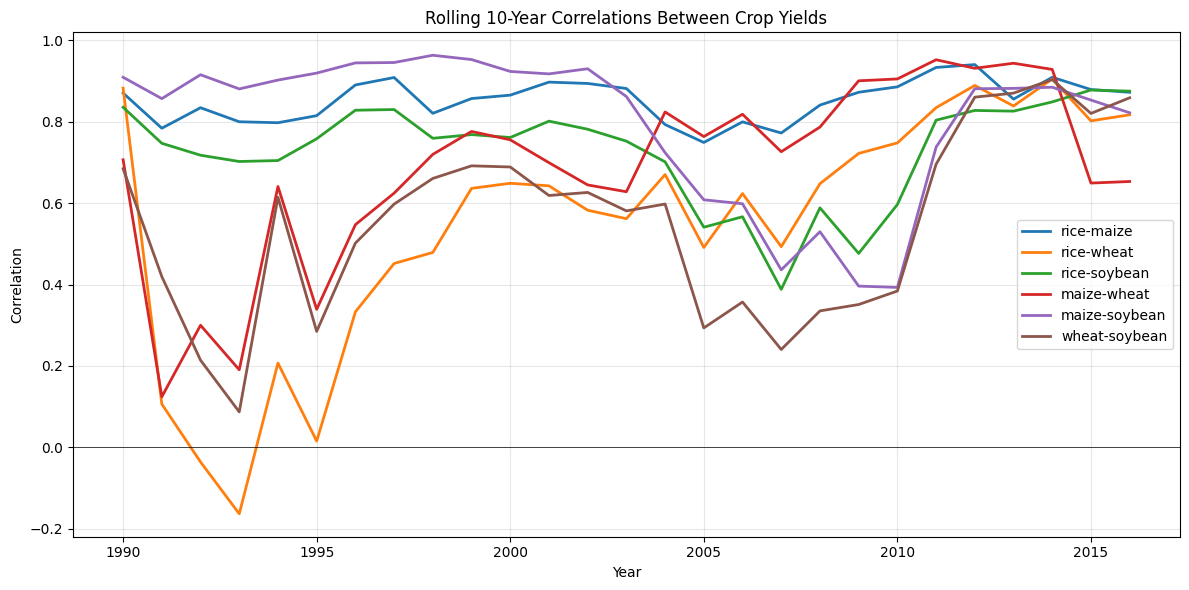

In [14]:
analysis.plot_rolling_correlations(window=10)

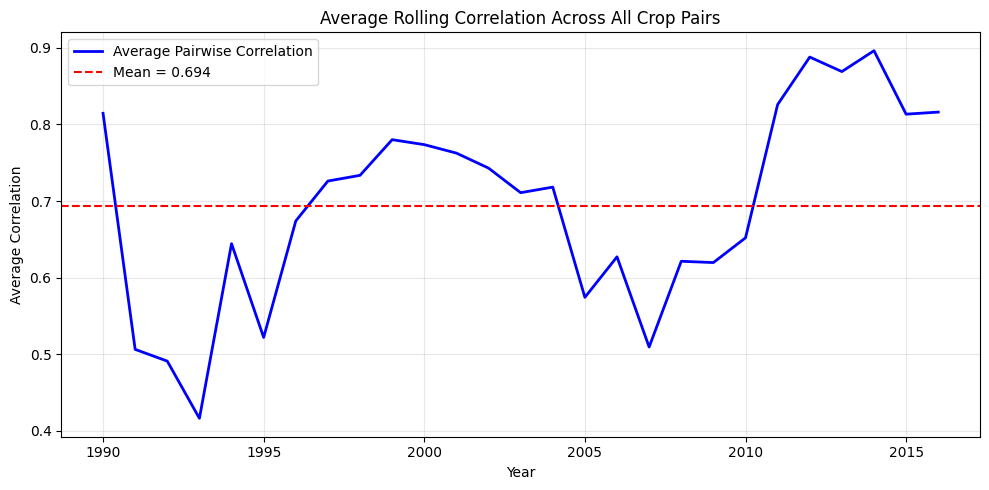

In [15]:
rolling_corrs_clean = rolling_corrs.dropna()
avg_rolling = rolling_corrs_clean.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(avg_rolling.index, avg_rolling.values, 'b-', linewidth=2, label='Average Pairwise Correlation')
plt.axhline(y=avg_rolling.mean(), color='red', linestyle='--', label=f'Mean = {avg_rolling.mean():.3f}')
plt.xlabel('Year')
plt.ylabel('Average Correlation')
plt.title('Average Rolling Correlation Across All Crop Pairs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Decade-by-Decade Comparison

Compare correlations and volatility across decades.

In [16]:
decade_results = analysis.decade_comparison()

print("Decade Comparison Summary:")
print("="*60)
for decade, stats in decade_results.items():
    print(f"\n{decade} ({stats['years']}, n={stats['n_years']})")
    print(f"  Avg Pairwise Correlation: {stats['avg_pairwise_correlation']:.3f}")
    print(f"  Portfolio Volatility:     {stats['portfolio_volatility']:.3f}")

Decade Comparison Summary:

1980s (1981-1989, n=9)
  Avg Pairwise Correlation: 0.832
  Portfolio Volatility:     0.545

1990s (1990-1999, n=10)
  Avg Pairwise Correlation: 0.780
  Portfolio Volatility:     0.308

2000s (2000-2009, n=10)
  Avg Pairwise Correlation: 0.620
  Portfolio Volatility:     0.247

2010s (2010-2016, n=7)
  Avg Pairwise Correlation: 0.509
  Portfolio Volatility:     0.262


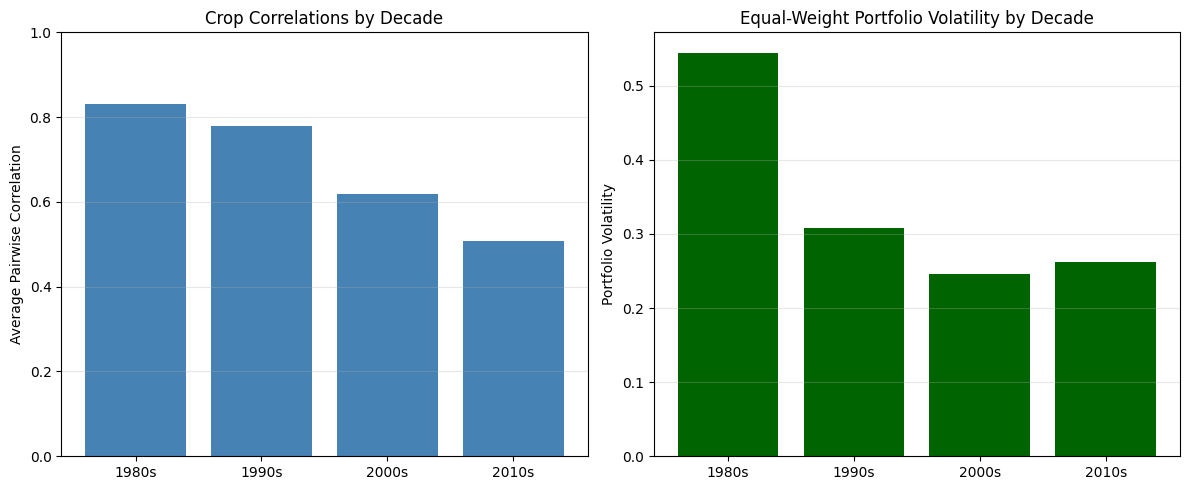

In [17]:
decades = list(decade_results.keys())
avg_corrs = [decade_results[d]['avg_pairwise_correlation'] for d in decades]
port_vols = [decade_results[d]['portfolio_volatility'] for d in decades]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(decades, avg_corrs, color='steelblue')
axes[0].set_ylabel('Average Pairwise Correlation')
axes[0].set_title('Crop Correlations by Decade')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(decades, port_vols, color='darkgreen')
axes[1].set_ylabel('Portfolio Volatility')
axes[1].set_title('Equal-Weight Portfolio Volatility by Decade')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Interpretation

### Key Findings

Analyze the results to answer:
1. **Trend in correlations**: Are crops becoming more or less correlated over time?
2. **Diversification implications**: If correlations are increasing, diversification benefits may be weakening.
3. **Climate signal**: Changes in correlation patterns could indicate climate-related shifts in yield dynamics.

In [18]:
avg_rolling_clean = avg_rolling.dropna()
x = np.arange(len(avg_rolling_clean))
y = avg_rolling_clean.values

slope, intercept = np.polyfit(x, y, 1)

print("Correlation Trend Analysis:")
print(f"  Starting avg correlation: {y[0]:.3f}")
print(f"  Ending avg correlation:   {y[-1]:.3f}")
print(f"  Change per year:          {slope:.4f}")
print(f"  Total change:             {(y[-1] - y[0]):.3f}")

if slope > 0.005:
    print("\n  → Correlations are INCREASING over time.")
    print("  → Diversification benefits may be weakening.")
elif slope < -0.005:
    print("\n  → Correlations are DECREASING over time.")
    print("  → Diversification benefits may be strengthening.")
else:
    print("\n  → Correlations are relatively STABLE over time.")
    print("  → Diversification benefits appear consistent.")

Correlation Trend Analysis:
  Starting avg correlation: 0.815
  Ending avg correlation:   0.816
  Change per year:          0.0086
  Total change:             0.002

  → Correlations are INCREASING over time.
  → Diversification benefits may be weakening.
